# Data exploration

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp (expressed as POSIX time).
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- totals - This set of columns mostly includes high-level aggregate data.


In [1]:
import pandas as pd
import numpy as np
import json
import gc
from ast import literal_eval
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

When try to load the data, I tried many ways to load it, some ways can load fast, but I can't use these ways as my laptop is not power enough. And some way may load it very slow.

Here I use gc package to reduce the memory used when loading the data, this way perform well.

First, let's count how many rows we will load.

In [14]:
!wc -l train_v2.csv

 1708338 train_v2.csv


In [2]:
j_col = ['device', 'geoNetwork', 'totals', 'trafficSource']

There are some json columns in this dataset, some of them can handled when load the data, and some of them are complex, I will handel them later.

In [3]:
gc.enable()
def load_data(file_path):
    j_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    re_df = pd.DataFrame()
    dfs = pd.read_csv(file_path, converters={column: json.loads for column in j_col}, 
                      dtype={'fullVisitorId': 'str'}, chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        df = df.drop('hits', axis=1)
        re_df= pd.concat([re_df, df], axis=0).reset_index(drop=True)
        del df
        gc.collect()
    return re_df

In [4]:
train_df = load_data('train_v2.csv')

In [5]:
train_df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{'browser': 'Firefox', 'browserVersion': 'not ...",3162355547410993243,"{'continent': 'Europe', 'subContinent': 'Weste...",Not Socially Engaged,"{'visits': '1', 'hits': '1', 'pageviews': '1',...","{'campaign': '(not set)', 'source': 'google', ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",8934116514970143966,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...",{'referralPath': '/a/google.com/transportation...,1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",7992466427990357681,"{'continent': 'Americas', 'subContinent': 'Nor...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': '(direct)'...",1508201613,1,1508201613
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",9075655783635761930,"{'continent': 'Asia', 'subContinent': 'Western...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': 'google', ...",1508169851,1,1508169851
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",6960673291025684308,"{'continent': 'Americas', 'subContinent': 'Cen...",Not Socially Engaged,"{'visits': '1', 'hits': '2', 'pageviews': '2',...","{'campaign': '(not set)', 'source': 'google', ...",1508190552,1,1508190552


In [6]:
train_df.shape

(1708337, 12)

The number of rows just as we expect.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 12 columns):
channelGrouping         object
customDimensions        object
date                    int64
device                  object
fullVisitorId           object
geoNetwork              object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                 int64
visitNumber             int64
visitStartTime          int64
dtypes: int64(4), object(8)
memory usage: 156.4+ MB


## Data explore

#### Change POSIX timestamp to readable time.

In [8]:
from datetime import datetime

In [9]:
train_df['visitStartTime'] = train_df['visitStartTime'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [10]:
train_df['visitStartTime'] = pd.to_datetime(train_df['visitStartTime'])

In [11]:
min(train_df['visitStartTime'])

Timestamp('2016-08-01 07:00:12')

In [12]:
max(train_df['visitStartTime'])

Timestamp('2018-05-01 06:56:58')

As we can see, this dataset mainly contains the data of Google Store from 2016-08-01 to 2018-05-01.

As we change the type of it to datetime, we can get useful information like day, month, the day of week, when data mining.

### Handle json columns.

Let's flat the json columns.

In [17]:
for column in j_col:
    column_as_df = json_normalize(train_df[column])
    column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
    train_df = train_df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

The customDimensions column is also json column, but it is a little complex to handle.

In [20]:
column_as_df = json_normalize(train_df['customDimensions'].apply(lambda x: literal_eval(x)[0] if x != "[]" else {'index': 'NaN', 'value': 'NaN'}))
column_as_df.columns = [f"{'customDimensions'}_{subcolumn}" for subcolumn in column_as_df.columns]
train_df = train_df.drop('customDimensions', axis=1).merge(column_as_df, right_index=True, left_index=True)

In [21]:
train_df.shape

(1708337, 60)

In [22]:
pd.set_option('display.max_columns', 65)


In [23]:
train_df.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_index,customDimensions_value
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google,4,EMEA
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,4,North America
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,Northern America,NaN,2,1,2,1,38,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct),4,No

Here I flatten all json columns expect hits, which will handle later. And I got 60 columns.

### Value to predict

In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict.

Since we already flatten the JSON columns, we can check the transactionRevenue column directly.

In [25]:
tR_cnt = train_df.totals_transactionRevenue.value_counts(dropna=False)
tR_cnt

NaN           1689823
16990000          308
19990000          248
39980000          220
18990000          219
21990000          211
33590000          203
17590000          188
44790000          185
13590000          179
10990000          163
15990000          155
79990000          152
55990000          150
41590000          149
19190000          147
35180000          119
59990000          116
15190000          113
59970000          102
24990000           88
27180000           81
99990000           76
47990000           74
43980000           73
33980000           71
23990000           70
27190000           65
12990000           64
8790000            61
               ...   
2687400000          1
251910000           1
94310000            1
123960000           1
93500000            1
412250000           1
51720000            1
652740000           1
141510000           1
228000000           1
186440000           1
223080000           1
142240000           1
223100000           1
44290000  

In [28]:
tR_cnt[0]/train_df.shape[0]

0.989162559846213

The $98.9\%$ of value we will predict is NaN, which means this customer didn't spend money in this view, so I cnage this NaN value to 0.

In [29]:
train_df.totals_transactionRevenue.fillna(0,inplace=True)

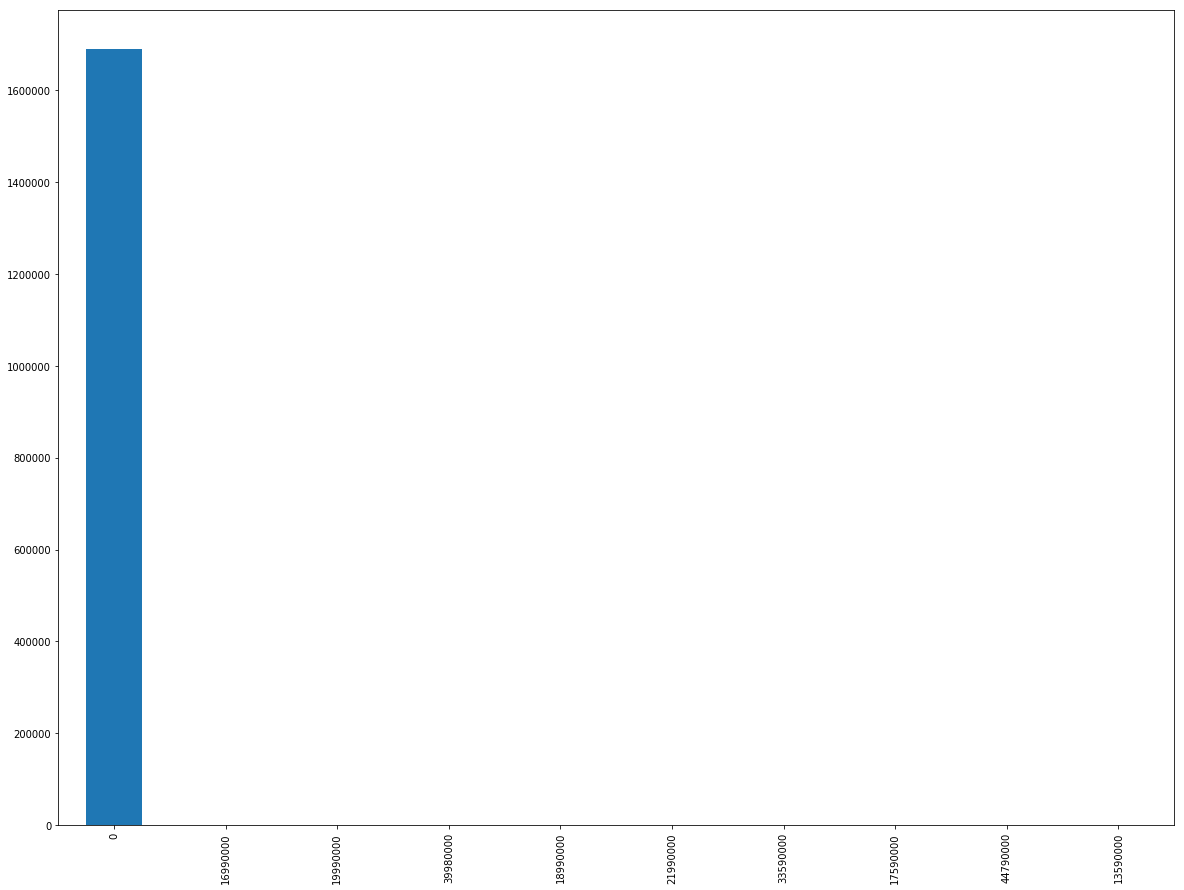

In [30]:
train_df.totals_transactionRevenue.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

Let's plot the histogram of top 10 values, as we see 0 is such much, and we can't see other 9 values.

As Kaggle's Overview said, "The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue", the percentage of customers produce most of the revenue is really low.

### Other columns

Let's check other columns are useful or ont.

In [33]:
cols = train_df.columns.to_list()

Let's check the columns with consistent values, and these columns are useless when predict.

In [42]:
for col in cols:
    if len(train_df[col].value_counts())==1:
        print(col)

socialEngagementType
device_browserSize
device_browserVersion
device_flashVersion
device_language
device_mobileDeviceBranding
device_mobileDeviceInfo
device_mobileDeviceMarketingName
device_mobileDeviceModel
device_mobileInputSelector
device_operatingSystemVersion
device_screenColors
device_screenResolution
geoNetwork_cityId
geoNetwork_latitude
geoNetwork_longitude
geoNetwork_networkLocation
totals_bounces
totals_newVisits
totals_visits
trafficSource_adwordsClickInfo.criteriaParameters
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_campaignCode
trafficSource_isTrueDirect


Let's check the channel via which the user came to the Store.

In [34]:
train_df.channelGrouping.value_counts()

Organic Search    738963
Social            354971
Direct            273134
Referral          211307
Display            51283
Paid Search        45627
Affiliates         32915
(Other)              137
Name: channelGrouping, dtype: int64

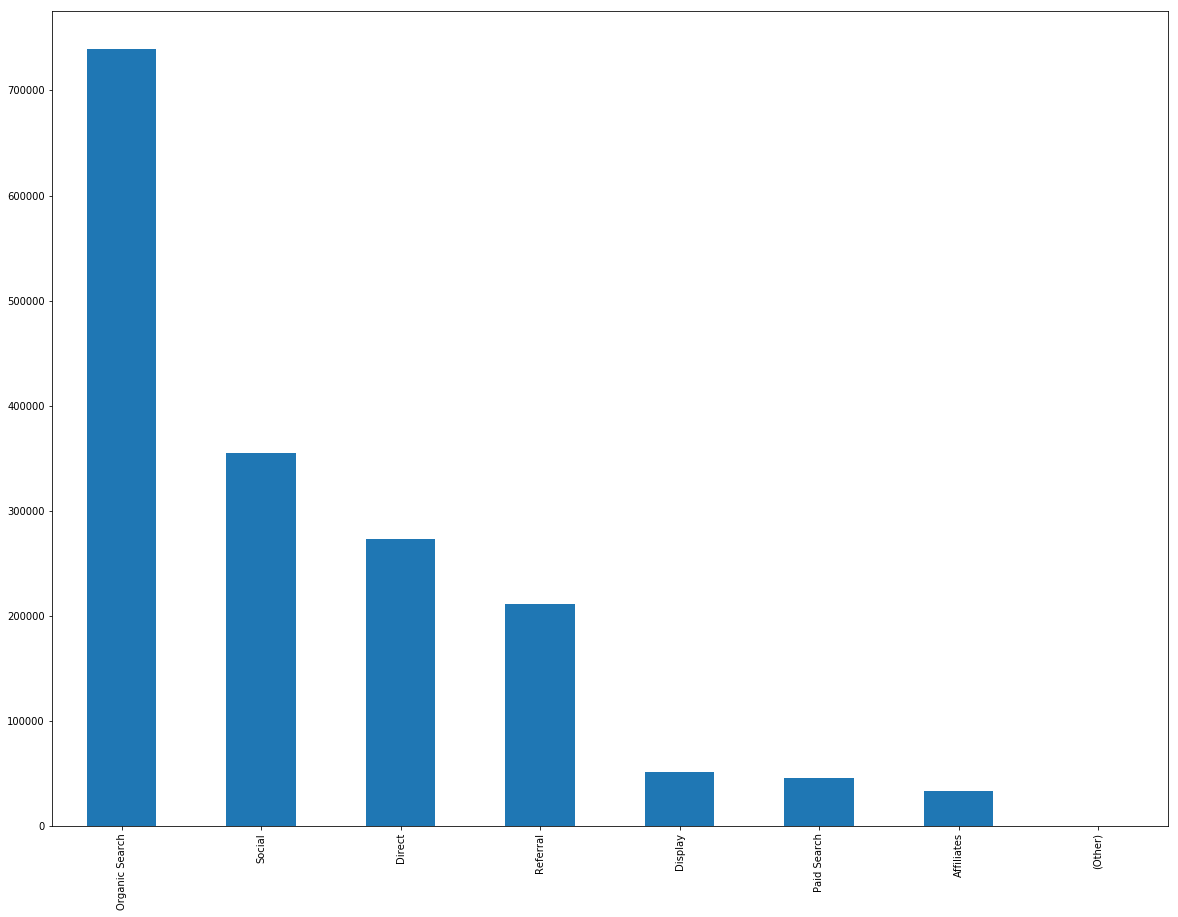

In [40]:
train_df.channelGrouping.value_counts().plot.bar(figsize=(20,15))

In [36]:
train_df['customDimensions_index'].value_counts()

4      1375102
NaN     333235
Name: customDimensions_index, dtype: int64

The customDimensions_index column is also not that useful.

In [37]:
train_df['customDimensions_value'].value_counts()

North America      768223
NaN                333235
EMEA               313991
APAC               222071
South America       45553
Central America     25264
Name: customDimensions_value, dtype: int64

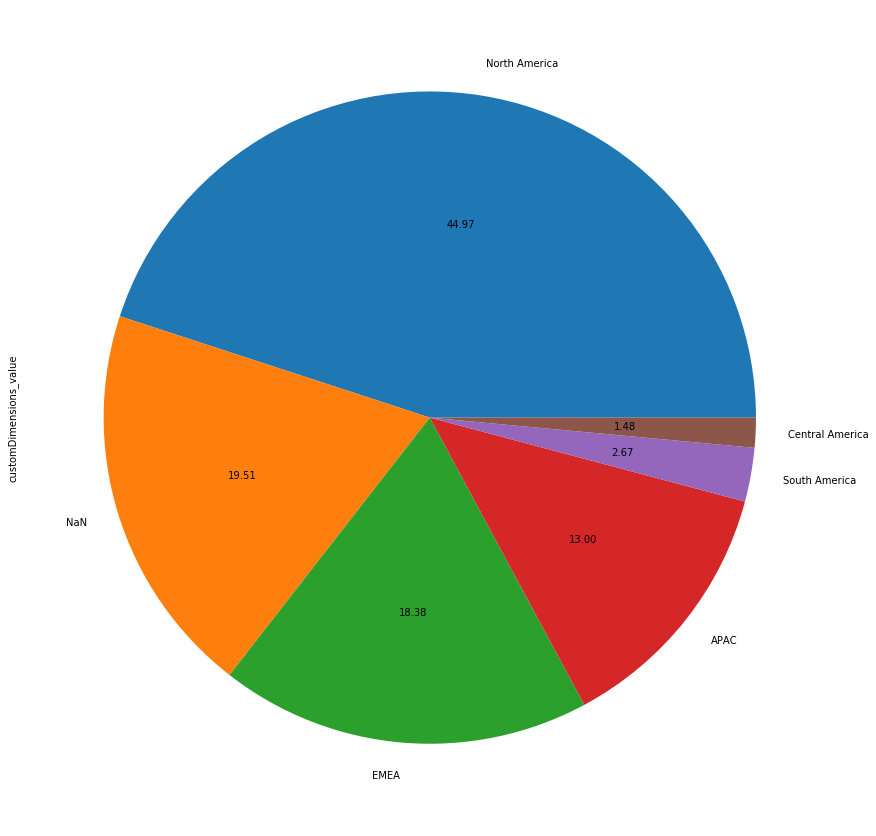

In [44]:
train_df['customDimensions_value'].value_counts().plot.pie(figsize=(20,15), autopct="%.2f")

We can see $44.97\%$ GStore customers are from North America.

#### Device

Let's check columns come from device json column.

In [45]:
device = [i for i in cols if i.startswith('device')]
device

['device_browser',
 'device_browserSize',
 'device_browserVersion',
 'device_deviceCategory',
 'device_flashVersion',
 'device_isMobile',
 'device_language',
 'device_mobileDeviceBranding',
 'device_mobileDeviceInfo',
 'device_mobileDeviceMarketingName',
 'device_mobileDeviceModel',
 'device_mobileInputSelector',
 'device_operatingSystem',
 'device_operatingSystemVersion',
 'device_screenColors',
 'device_screenResolution']

In [51]:
for dev in device:
    print(dev + ':')
    print(train_df[dev].value_counts(dropna=False))
    print('\n')
    print('-'*50)
    print('\n')

device_browser:
Chrome                                                  1173056
Safari                                                   312165
Firefox                                                   63845
Internet Explorer                                         35474
Android Webview                                           34266
Edge                                                      20543
Samsung Internet                                          15792
Opera Mini                                                15018
Safari (in-app)                                           14207
Opera                                                      9585
UC Browser                                                 5313
YaBrowser                                                  3045
Amazon Silk                                                1467
Coc Coc                                                    1242
Android Browser                                             941
Mozilla Compatible Agent

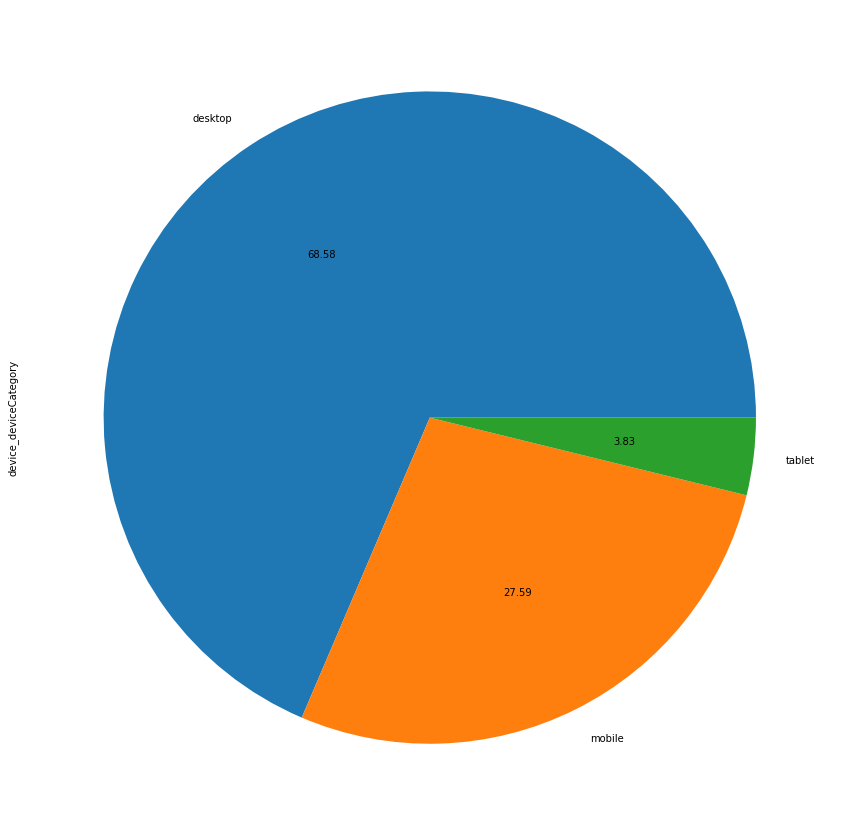

In [50]:
train_df.device_deviceCategory.value_counts(dropna=False).plot.pie(figsize=(20,15), autopct="%.2f")

From device_deviceCategory column, we can see $68.58\%$ devices are desktop, $27.59\%$ are mobile, and $3.83\%$ are tablet. As this dataset is from 2016-08-01 to 2018-05-01, the result may be different now.

Useful columns: 'device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem'.

In [2]:
debive_ucol: ['device_browser', 'device_deviceCategory', 'device_isMobile', 'device_operatingSystem']

#### GeoNetwork

CustomDimensions_value column already provide continent information, in the geoNetwork json columns, there are more detail information.

In [62]:
geoNetwork = [i for i in cols if i.startswith('geoNetwork')]
geoNetwork

['geoNetwork_city',
 'geoNetwork_cityId',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_latitude',
 'geoNetwork_longitude',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_networkLocation',
 'geoNetwork_region',
 'geoNetwork_subContinent']

In [63]:
for gnw in geoNetwork:
    print(gnw + ':')
    print(train_df[gnw].value_counts(dropna=False))
    print('\n')
    print('-'*50)
    print('\n')

geoNetwork_city:
not available in demo dataset    932959
Mountain View                     74110
(not set)                         65867
New York                          49460
San Francisco                     36960
Sunnyvale                         27923
London                            23622
San Jose                          20141
Los Angeles                       17038
Chicago                           15143
Bangkok                           12468
Bengaluru                         11428
Ho Chi Minh City                  10393
Toronto                           10196
Istanbul                           9827
Seattle                            9566
Dublin                             9436
Sydney                             8951
Mumbai                             8563
Hyderabad                          8353
Paris                              8094
Chennai                            8046
Sao Paulo                          7828
Austin                             7289
Hanoi                  

(not set)                499049
unknown.unknown          269796
comcast.net               55486
rr.com                    28715
verizon.net               26547
ttnet.com.tr              17078
comcastbusiness.net       16826
hinet.net                 15933
virginm.net               12594
cox.net                   10722
sbcglobal.net             10596
google.com                 9997
prod-infinitum.com.mx      9925
optonline.net              9734
att.net                    9255
btcentralplus.com          9152
rima-tde.net               8078
3bb.co.th                  7832
vnpt.vn                    7662
asianet.co.th              7067
qwest.net                  6945
totbb.net                  6828
telecomitalia.it           6405
t-ipconnect.de             6117
airtelbroadband.in         5991
bell.ca                    5956
pldt.net                   5753
virtua.com.br              5399
bhn.net                    5363
amazonaws.com              5039
                          ...  
telplay.

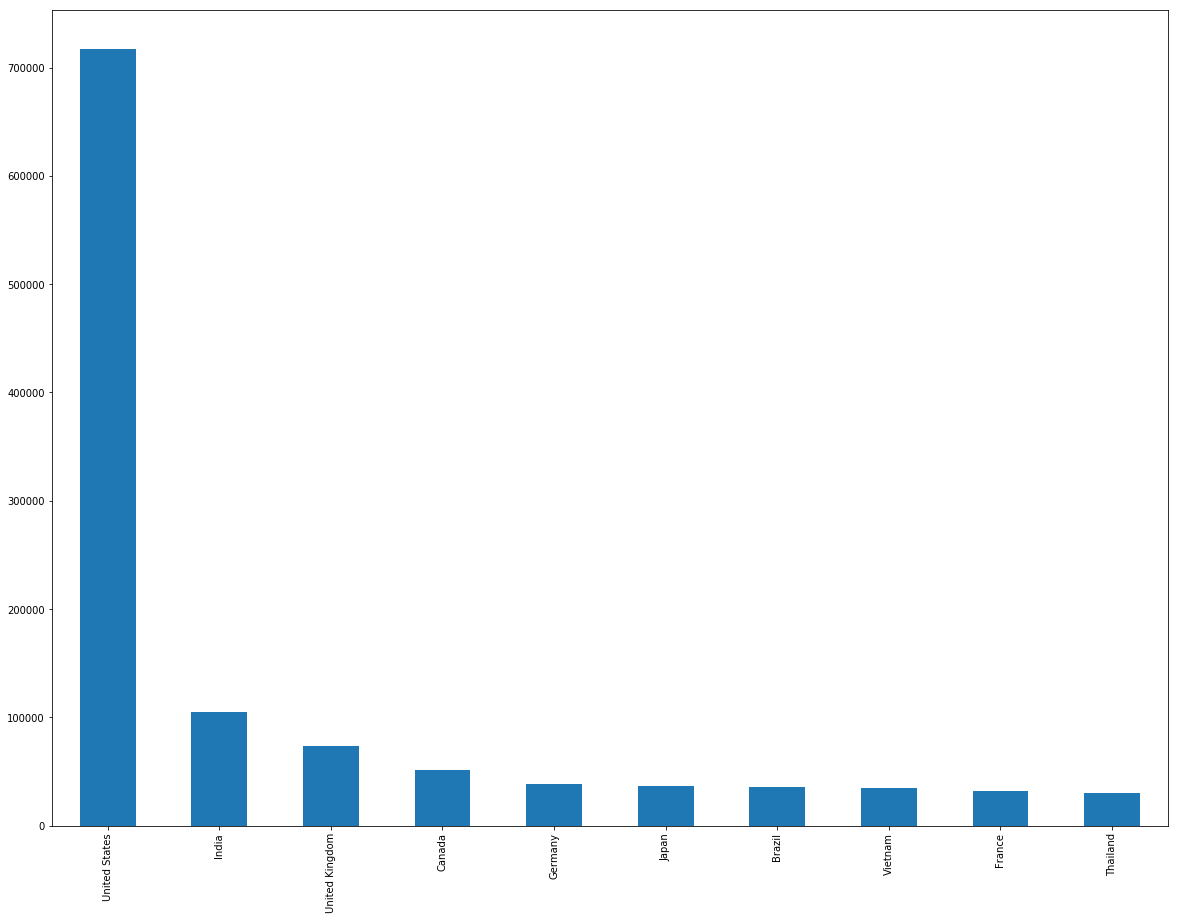

In [64]:
train_df.geoNetwork_country.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

In the histogram of top 10 country, we can see mainly customers are in United States, and the second country is India.

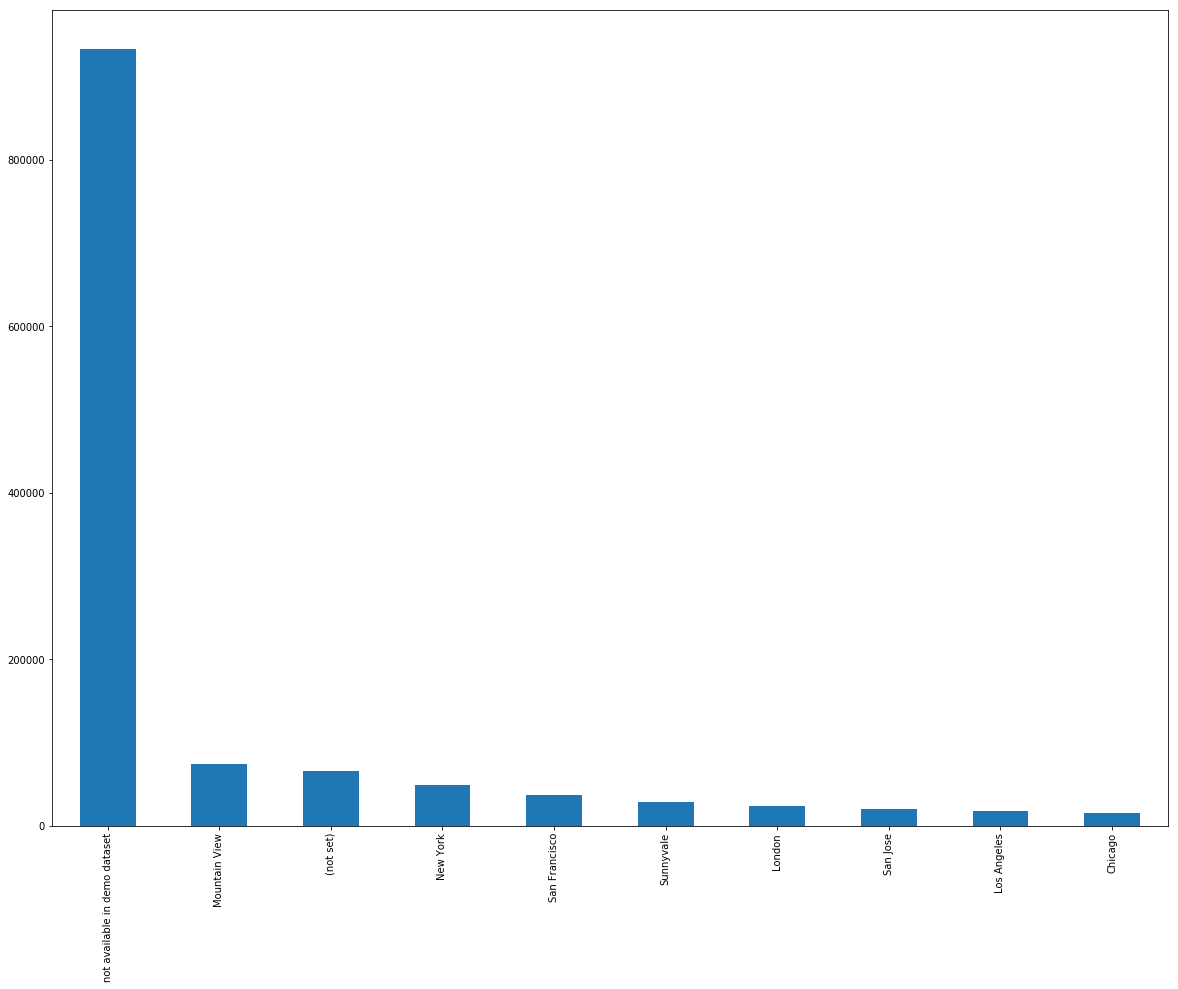

In [65]:
train_df.geoNetwork_city.value_counts(dropna=False)[:10].plot.bar(figsize=(20,15))

In the histogram of top 10 city, nearly $90\%$ data are not allowed to see or not set, and except these data, top 1 city is Mountain View, followed by New York and San Francisco.

Useful columns: 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent'.

In [3]:
geo_ucol = ['geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent']

#### Totals

In [66]:
totals = [i for i in cols if i.startswith('totals')]
totals

['totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'totals_sessionQualityDim',
 'totals_timeOnSite',
 'totals_totalTransactionRevenue',
 'totals_transactionRevenue',
 'totals_transactions',
 'totals_visits']

In [67]:
for total in totals:
    print(total + ':')
    print(train_df[total].value_counts(dropna=False))
    print('\n')
    print('-'*50)
    print('\n')

totals_bounces:
1      871578
NaN    836759
Name: totals_bounces, dtype: int64


--------------------------------------------------


totals_hits:
1      864064
2      237499
3      134435
4       80875
5       63687
6       46598
7       38137
8       29717
9       24999
10      20306
11      17506
12      14877
13      13033
14      11361
15      10017
16       8818
17       7682
18       6924
19       6149
20       5643
21       4938
22       4543
23       4056
24       3746
25       3400
26       3100
27       2698
28       2549
29       2317
30       2257
        ...  
292         1
265         1
406         1
353         1
347         1
186         1
233         1
238         1
361         1
246         1
216         1
249         1
445         1
221         1
422         1
183         1
252         1
251         1
276         1
382         1
245         1
400         1
283         1
349         1
303         1
273         1
228         1
331         1
308         1
328         1

Useful columns: 'totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactions'.

In [4]:
totals_ucol = ['totals_bounces', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_transactions']

#### TrafficSource

The traddicSource json column is mainly how the customer get to the Gstore page.

In [68]:
trafficSource = [i for i in cols if i.startswith('trafficSource')]
trafficSource

['trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.criteriaParameters',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_adwordsClickInfo.page',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_campaign',
 'trafficSource_campaignCode',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source']

In [69]:
for ts in trafficSource:
    print(ts + ':')
    print(train_df[ts].value_counts(dropna=False))
    print('\n')
    print('-'*50)
    print('\n')

trafficSource_adContent:
NaN                                            1643600
Google Merchandise Store                         39566
Google Merchandise Collection                     6762
Placement Accessores 300 x 250                    3040
Smart display ad - 8/17/2017                      2664
Display Ad created 3/11/14                        2344
Google Online Store                               1773
Official Google Merchandise                        866
Ad from 12/15/17                                   853
Full auto ad IMAGE ONLY                            822
Placement Drinkware 300x250                        653
Ad from 12/13/16                                   610
Ad from 11/3/16                                    489
{KeyWord:Google Brand Items}                       418
Display Ad created 3/11/15                         392
Placement Accessories 336 x 280                    308
BQ                                                 287
Placement Accessories 300 x 250         

NaN    1633063
1        73913
2         1057
3          172
4           80
5           30
6           10
7            6
9            3
8            1
14           1
12           1
Name: trafficSource_adwordsClickInfo.page, dtype: int64


--------------------------------------------------


trafficSource_adwordsClickInfo.slot:
NaN                       1633063
RHS                         42750
Top                         32447
Google Display Network         77
Name: trafficSource_adwordsClickInfo.slot, dtype: int64


--------------------------------------------------


trafficSource_campaign:
(not set)                                                               1604526
Data Share Promo                                                          32914
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS                    24410
1000557 | GA | US | en | Hybrid | GDN Remarketing                         15149
AW - Dynamic Search Ads Whole Site                                        15146
A

NaN                                                                                                                                                                                                                                   1142073
/                                                                                                                                                                                                                                      138293
/yt/about/                                                                                                                                                                                                                              79163
/analytics/web/                                                                                                                                                                                                                         33112
/yt/about/tr/                                   

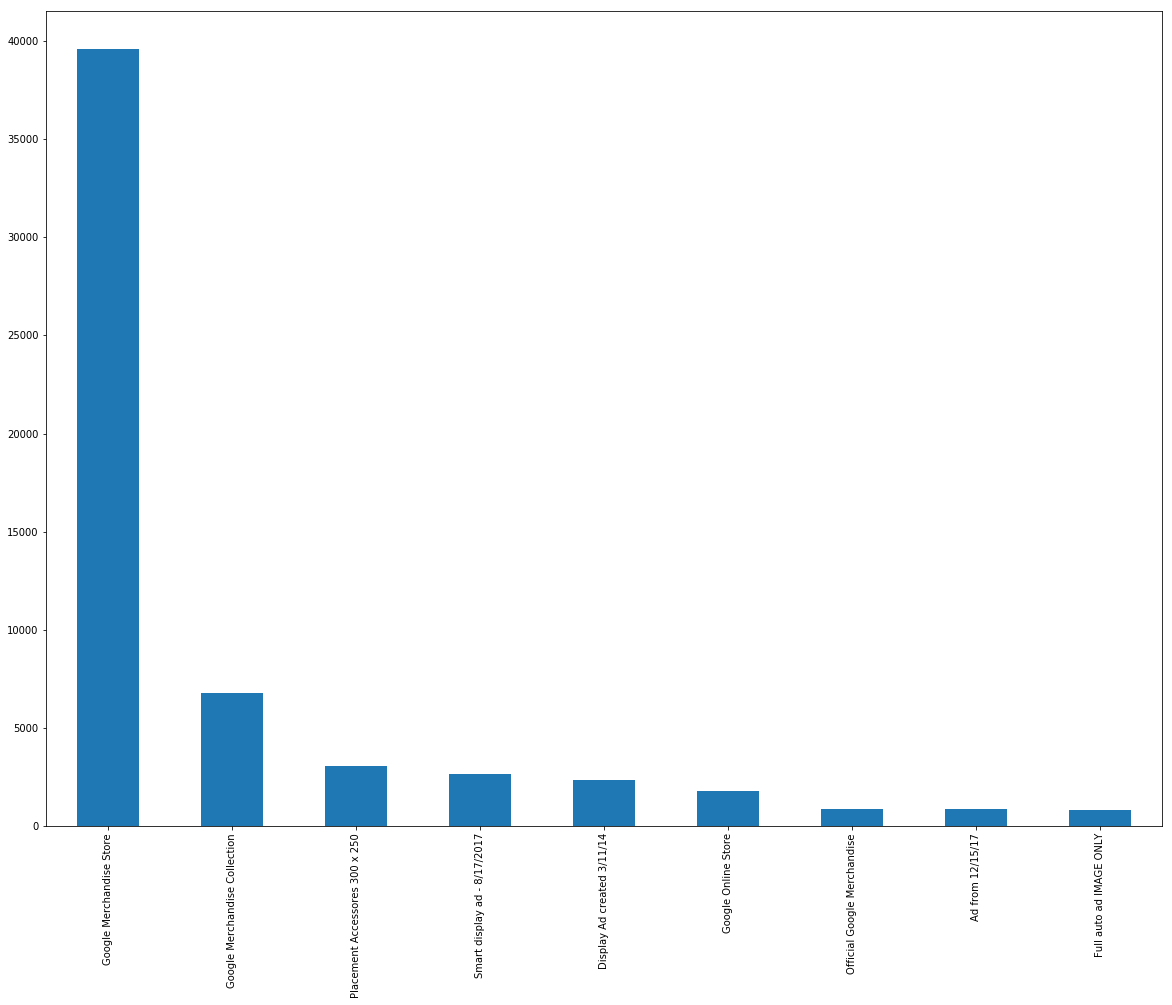

In [70]:
train_df.trafficSource_adContent.value_counts(dropna=False)[1:10].plot.bar(figsize=(20,15))

Useful columns: 'trafficSource_adContent', 'trafficSource_campaign', 'trafficSource_adwordsClickInfo.page', 'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source'.

In [71]:
trafficSource_ucol = [ 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_isTrueDirect', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source']

#### Handling with hits chunk

In [2]:
gc.enable()
def load_hits(file_path):
    j_col = ['device', 'geoNetwork', 'totals', 'trafficSource']
    re_df = pd.DataFrame()
    dfs = pd.read_csv(file_path, converters={column: json.loads for column in j_col}, 
                      dtype={'fullVisitorId': 'str'}, chunksize=10000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        df = json_normalize(df['hits'].apply(lambda x: literal_eval(x)[0] if x != "[]" else literal_eval("{}")))
        re_df= pd.concat([re_df, df], axis=0).reset_index(drop=True)
        del df
        gc.collect()
    return re_df

### The cell below may run more than 8 hours.

In [ ]:
hits_chunk = load_hits('train_v2.csv')

In [4]:
hits_chunk.head()

,appInfo.exitScreenName,appInfo.landingScreenName,appInfo.screenDepth,appInfo.screenName,contentGroup.contentGroup1,contentGroup.contentGroup2,contentGroup.contentGroup3,contentGroup.contentGroup4,contentGroup.contentGroup5,contentGroup.contentGroupUniqueViews1,...,promotionActionInfo.promoIsClick,promotionActionInfo.promoIsView,publisher_infos,referer,social.hasSocialSourceReferral,social.socialInteractionNetworkAction,social.socialNetwork,time,transaction.currencyCode,type
0,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,shop.googlemerchandisestore.com/google+redesig...,(not set),Bags,(not set),(not set),(not set),NaN,...,NaN,NaN,[],https://www.google.co.uk/search?q=water+bottle...,No,:,(not set),0,USD,PAGE
1,shop.googlemerchandisestore.com/asearch.html,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://sites.google.com/a/google.com/transpor...,No,:,(not set),0,NaN,PAGE
2,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.googlemerchandisestore.com/,No,:,(not set),0,NaN,PAGE
3,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.google.com.tr/,No,:,(not set),0,NaN,PAGE
4,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/home,0,shop.googlemerchandisestore.com/home,(not set),(not set),(not set),(not set),(not set),NaN,...,NaN,True,[],https://www.google.com.mx/,No,:,(not set),0,NaN,PAGE


In [5]:
hits_chunk.columns

Index(['appInfo.exitScreenName', 'appInfo.landingScreenName',
       'appInfo.screenDepth', 'appInfo.screenName',
       'contentGroup.contentGroup1', 'contentGroup.contentGroup2',
       'contentGroup.contentGroup3', 'contentGroup.contentGroup4',
       'contentGroup.contentGroup5', 'contentGroup.contentGroupUniqueViews1',
       'contentGroup.contentGroupUniqueViews2',
       'contentGroup.contentGroupUniqueViews3',
       'contentGroup.previousContentGroup1',
       'contentGroup.previousContentGroup2',
       'contentGroup.previousContentGroup3',
       'contentGroup.previousContentGroup4',
       'contentGroup.previousContentGroup5', 'customDimensions',
       'customMetrics', 'customVariables', 'dataSource',
       'eCommerceAction.action_type', 'eCommerceAction.option',
       'eCommerceAction.step', 'eventInfo.eventAction',
       'eventInfo.eventCategory', 'eventInfo.eventLabel',
       'exceptionInfo.isFatal', 'experiment', 'hitNumber', 'hour',
       'isEntrance', 'isExit', 

In [6]:
hcc = hits_chunk.columns.to_list()
for i in hcc:
    print(i + ':')
    print(hits_chunk[i].value_counts(dropna=False))
    print('\n')
    print('-'*50)
    print('\n')

appInfo.exitScreenName:
www.googlemerchandisestore.com/home                                                                                                42496
shop.googlemerchandisestore.com/home                                                                                               39230
shop.googlemerchandisestore.com/google+redesign/shop+by+brand/youtube                                                              25946
shop.googlemerchandisestore.com/basket.html                                                                                         4972
shop.googlemerchandisestore.com/signin.html                                                                                         4952
shop.googlemerchandisestore.com/asearch.html                                                                                        4375
shop.googlemerchandisestore.com/google+redesign/apparel/mens/mens+t+shirts                                                          3489
shop.googlemercha

(not set)      130288
Brands          35748
Apparel         18267
Bags             3760
Accessories      3151
Drinkware        2783
Electronics      2554
Office           2103
Nest             1050
NaN               162
Lifestyle         134
Name: contentGroup.contentGroup2, dtype: int64


--------------------------------------------------


contentGroup.contentGroup3:
(not set)    195390
Mens           3764
Womens          684
NaN             162
Name: contentGroup.contentGroup3, dtype: int64


--------------------------------------------------


contentGroup.contentGroup4:
(not set)    199838
NaN             162
Name: contentGroup.contentGroup4, dtype: int64


--------------------------------------------------


contentGroup.contentGroup5:
(not set)    199838
NaN             162
Name: contentGroup.contentGroup5, dtype: int64


--------------------------------------------------


contentGroup.contentGroupUniqueViews1:
NaN    199190
1         810
Name: contentGroup.contentGroupUniqueVi

True    199327
NaN        673
Name: isEntrance, dtype: int64


--------------------------------------------------


isExit:
True    101485
NaN      98515
Name: isExit, dtype: int64


--------------------------------------------------


isInteraction:
True    199838
NaN        162
Name: isInteraction, dtype: int64


--------------------------------------------------


item.currencyCode:
NaN    148500
USD     51500
Name: item.currencyCode, dtype: int64


--------------------------------------------------


latencyTracking.domContentLoadedTime:
NaN      199989
4513          1
10445         1
13976         1
3113          1
829           1
1306          1
3079          1
5444          1
2274          1
2883          1
4232          1
Name: latencyTracking.domContentLoadedTime, dtype: int64


--------------------------------------------------


latencyTracking.domInteractiveTime:
NaN      199989
5276          1
4513          1
13929         1
3113          1
829           1
1306          1


Google Online Store                                                                                                         61820
Home                                                                                                                        59014
YouTube | Shop by Brand | Google Merchandise Store                                                                          32976
Men's T-Shirts | Apparel | Google Merchandise Store                                                                          6231
Page Unavailable                                                                                                             3568
The Google Merchandise Store - Log In                                                                                        3474
Apparel | Google Merchandise Store                                                                                           2025
Bags | Google Merchandise Store                                                           

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

(not set)        156656
YouTube           40527
Facebook           1240
reddit              436
Quora               378
Google Groups       209
Twitter             176
NaN                 162
VKontakte           133
Google+              56
Pinterest            12
LinkedIn              7
Pocket                5
wikiHow               1
Digg                  1
Hacker News           1
Name: social.socialNetwork, dtype: int64


--------------------------------------------------


time:
0      199838
NaN       162
Name: time, dtype: int64


--------------------------------------------------


transaction.currencyCode:
NaN    148500
USD     51500
Name: transaction.currencyCode, dtype: int64


--------------------------------------------------


type:
PAGE     199327
EVENT       511
NaN         162
Name: type, dtype: int64


--------------------------------------------------




It looks like all information of columns in hits chunk is already contained in other columns. For example, we can find information of dataSource column in trafficSource_referralPath column, information of hitNumber in totals_hits column. And the last but not least reason, this chunk will takes really much of time to load and flatten, so I drop this chunk in future analysis and prediction.